In [1]:
import pandas as pd
import numpy as np
import re
import string

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Definiciones

In [2]:
meses = ['202112','202201','202202','202203','202204','202205','202206',
         '202207','202208','202209','202210','202211','202212']   # Meses a analizar
seccion = 'economia'   # Sección para filtrar, si queda en blanco se usan todas las noticias
objeto = 3   # 1 solo titulos 2 solo cuerpo 3 ambos (default)

### Descarga y lectura del dataset

In [3]:
# Leemos todos los csvs mensuales
# Integramos todo en un único DataFrame

files = {}

for m in meses:
    try:
        url = 'https://github.com/fermasia/news-base/blob/main/files/' + m + '.csv.gz?raw=true'
        files[m] = pd.read_csv(url, compression='gzip')
    except:
        meses.remove(m)

df = pd.concat(files.values(), ignore_index=True)

#del files

In [4]:
for m in files.keys():
    print(m,len(files[m].link))

202112 25090
202201 30363
202202 23109
202203 18172
202204 13931
202205 21281
202206 21706
202207 18497


In [5]:
df[df.category != 'mundo'].source.value_counts()

la_nacion    30244
pagina_12    17940
clarin       16434
infobae       6977
Name: source, dtype: int64

### Vamos a construir un campo que tenga el dato de AAAAMM (YYYYMM)
##### Para agrupar luego por medio y por mes-año

In [6]:
df['date'] = pd.to_datetime(df['date'], errors='coerce', utc=True).dt.tz_convert('America/Argentina/Buenos_Aires')

# Filter errors in dates
df = df[df['date'] > '2021-11-30']

df['yyyymm'] = df['date'].dt.year.astype(str) + '-' + df['date'].dt.month.astype(str)

In [7]:
df.head(1)

,source,category,date,title,text,link,yyyymm
0,la_nacion,politica,2021-12-07 00:28:54-03:00,Domingo Cavallo pronosticó una inflación del 6...,El exministro de Economía Domingo Cavallo sost...,https://www.lanacion.com.ar/politica/domingo-c...,2021-12


In [8]:
df[df.category != 'mundo'].groupby(['category','source'])\
                          .count()['link'].reset_index()\
                          .pivot(index='category',columns='source',values='link').fillna(0).astype(int)

source,clarin,infobae,la_nacion,pagina_12
category,,,,
deportes,2989,538,2950,903
economia,3999,2060,4483,2511
opinion,750,0,1193,0
politica,5213,2540,4331,3835
portada,0,0,0,6389
sociedad,3483,1839,17287,4246


In [9]:
df[df.category != 'mundo'].groupby(['category','yyyymm'])\
                          .count()['link'].reset_index()\
                          .pivot(index='category',columns='yyyymm',values='link').fillna(0).astype(int)

yyyymm,2021-12,2022-1,2022-2,2022-3,2022-4,2022-5,2022-6,2022-7
category,,,,,,,,
deportes,10,0,0,0,1734,1965,1921,1750
economia,1481,1654,1540,1731,1328,1810,1899,1610
opinion,178,213,197,222,255,294,340,244
politica,1816,1809,1927,2177,1732,2263,2474,1721
portada,660,770,742,802,595,1000,1068,752
sociedad,4216,5090,4334,4344,3224,2721,1747,1179


In [10]:
df[df.category != 'mundo']['yyyymm'].value_counts()

2022-5     10053
2022-1      9536
2022-6      9449
2022-3      9276
2022-4      8868
2022-2      8740
2021-12     8361
2022-7      7256
Name: yyyymm, dtype: int64

# Graficos

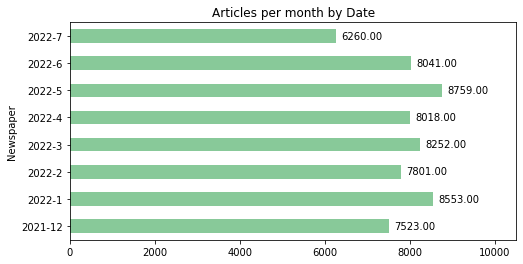

In [11]:
variable = 'yyyymm'
y_axis = 'Newspaper'
title = 'Articles per month by Date'

ax = df[~df.category.isin(['mundo','portada','opinion'])][variable].value_counts()\
.reset_index()\
.rename(columns={'index':y_axis})\
.sort_values(by=y_axis)\
.set_index(y_axis)\
.plot.barh(legend=False, figsize=(8,4), title=title, color = '#88c999')

max_x = df[~df.category.isin(['mundo','portada','opinion'])][variable].value_counts().max() * 1.2

ax.set_xlim(0,max_x)

for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 4), textcoords='offset points')


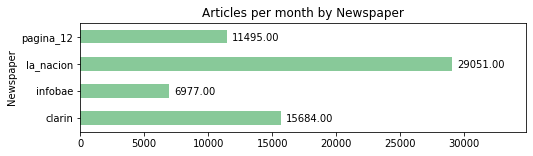

In [12]:
variable = 'source'
y_axis = 'Newspaper'
title = 'Articles per month by Newspaper'

ax = df[~df.category.isin(['mundo','portada','opinion'])][variable].value_counts()\
.reset_index()\
.rename(columns={'index':y_axis})\
.sort_values(by=y_axis)\
.set_index(y_axis)\
.plot.barh(legend=False, figsize=(8,2), title=title, color = '#88c999')

max_x = df[~df.category.isin(['mundo','portada','opinion'])][variable].value_counts().max() * 1.2

ax.set_xlim(0,max_x)

for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 3), textcoords='offset points')


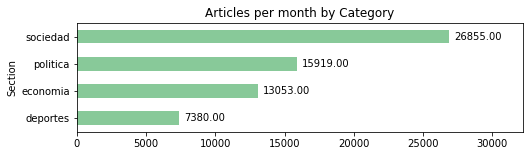

In [13]:
variable = 'category'
y_axis = 'Section'
title = 'Articles per month by Category'

ax = df[~df.category.isin(['mundo','portada','opinion'])][variable].value_counts()\
.reset_index()\
.rename(columns={'index':y_axis})\
.sort_values(by=y_axis)\
.set_index(y_axis)\
.plot.barh(legend=False, figsize=(8,2), title=title, color = '#88c999')

max_x = df[~df.category.isin(['mundo','portada','opinion'])][variable].value_counts().max() * 1.2

ax.set_xlim(0,max_x)

for p in ax.patches:
    ax.annotate("%.2f" % p.get_width(), (p.get_x() + p.get_width(), p.get_y()), xytext=(5, 4), textcoords='offset points')

##### Aprovechamos a ordenar las filas por medio y AAAAMM y reseteamos los índices para luego poder joinear

In [14]:
df.sort_values(by=['yyyymm','source'],ascending=True,inplace=True)
df.reset_index(drop=True,inplace=True) 

### Crear el corpus filtrando por sección

In [15]:
if seccion == '':
    corpus_df = df
else:
    corpus_df = df[df.category == seccion]
    
corpus_df['source'] = corpus_df['yyyymm'] + '_' + corpus_df['source']
sources_df = corpus_df['source'] # conservamos los origenes y el mes año para unir luego de procesar

if  objeto == 1:
    corpus_df = pd.DataFrame(corpus_df.title)
    col = 'title'

elif objeto == 2:
    corpus_df = pd.DataFrame(corpus_df.text)
    col = 'text'
else:
    corpus_df = pd.DataFrame(corpus_df.title + ' ' + corpus_df.text)
    col = 0

corpus_df.rename(columns={col:'text'},inplace=True)
corpus_df['text'] = corpus_df.text.astype(str)
corpus_bert = corpus_df['text'].copy()

/tmp/ipykernel_219/2066408061.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corpus_df['source'] = corpus_df['yyyymm'] + '_' + corpus_df['source']


In [16]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*\]\%;,"“”', ' ', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', '', text)
    text = text.replace('\xa0',' ')
    text = re.sub('[‘’“”…«»]', '', text)
    text = re.sub('\n', ' ', text)
    text = text.replace('?',' ')
    text = text.replace('¿',' ')
    # Eliminamos los caracteres especiales
    text = re.sub(r'\W', ' ', str(text))
    # Eliminado las palabras que tengo un solo caracter
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Sustituir los espacios en blanco en uno solo
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    return text

corpus_df['text'] = corpus_df.text.apply(clean_text)

In [17]:
stopwords_es = pd.read_csv('https://raw.githubusercontent.com/jbagnato/machine-learning/master/nlp/spanish.txt',header=None)[0].to_list()
aditional_sw = ['ciento','gobierno','argentina','window','t','terminación','año','si','no','dijo',\
                'país','política','años','año','uno','dos','tres','cuatro','cinco']
stopwords_es = stopwords_es + aditional_sw 

def remove_stopwords(text):
    stripped_text = [w for w in text.split() if w not in stopwords_es and not w.isdigit()]
    return ' '.join(word for word in stripped_text)

#def remove_word(text,word='terminación'):
#    stripped_text = [w for w in text.split() if word not in w]
#    return ' '.join(word for word in stripped_text)

corpus_df.text = corpus_df.text.apply(remove_stopwords)
#corpus_df.text = corpus_df.text.apply(remove_word)

In [18]:
complete_df = pd.merge(corpus_df, sources_df, left_index=True, right_index=True)

In [19]:
complete_df.head(2)

,text,source
20,roberto feletti defendió nuevos precios cuidad...,2021-12_clarin
21,negocia campo exportaciones carne maíz trigo c...,2021-12_clarin


## Vamos a hacer WordClouds por mes y por medio

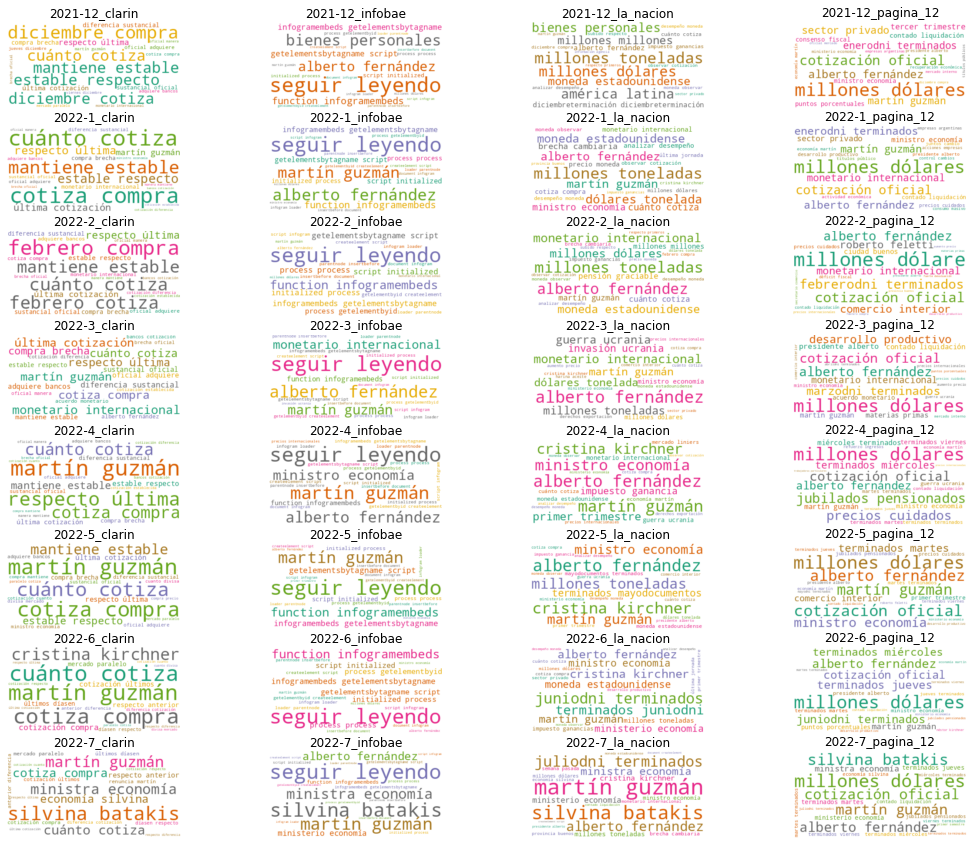

In [20]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

#def crear_wordclouds(df):
#    wc = WordCloud(background_color="white", colormap="Dark2",
#                   max_font_size=150, random_state=42)
#    bag = df.text[df.source == source].str.cat(sep=' ')
#    wc.generate(bag)

def crear_wordclouds(df):
    wc = WordCloud(background_color="white", colormap="Dark2",collocation_threshold=3,min_word_length=6,
                   max_font_size=100, random_state=42, max_words=20)

    plt.rcParams['figure.figsize'] = [18,15]

    sources = complete_df.source.unique().tolist()

    index = 0

    width = 4
    height = int(np.round(len(complete_df.source.unique()) / width,0))

    for source in sources:
        index += 1
        bag = df.text[df.source == source].str.cat(sep=' ')
        wc.generate(bag)
        plt.subplot(height, width, index)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(source)

    plt.show()
    
crear_wordclouds(complete_df)

# Detección de Tópicos

In [21]:
import json, re
import pandas as pd 
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import ToktokTokenizer

In [22]:
tokenizer = ToktokTokenizer() 
corpus_df["Tokens"] = corpus_df.text.apply(tokenizer.tokenize)
corpus_df.head()

,text,Tokens
20,roberto feletti defendió nuevos precios cuidad...,"[roberto, feletti, defendió, nuevos, precios, ..."
21,negocia campo exportaciones carne maíz trigo c...,"[negocia, campo, exportaciones, carne, maíz, t..."
22,inflación da tregua esperan aceleración precio...,"[inflación, da, tregua, esperan, aceleración, ..."
23,negociación washington buscan entendimiento té...,"[negociación, washington, buscan, entendimient..."
24,nuevos hábitos menos gasto shoppings alimentos...,"[nuevos, hábitos, menos, gasto, shoppings, ali..."


In [23]:
stemmer = SnowballStemmer("spanish")

def stem_palabras(tokens):
    """
    Reduce cada palabra de una lista dada a su raíz.
    """
    return [stemmer.stem(token) for token in tokens]

corpus_df["Stems"] = corpus_df.Tokens.apply(stem_palabras)

corpus_df.head()

,text,Tokens,Stems
20,roberto feletti defendió nuevos precios cuidad...,"[roberto, feletti, defendió, nuevos, precios, ...","[robert, feletti, defend, nuev, preci, cuid, e..."
21,negocia campo exportaciones carne maíz trigo c...,"[negocia, campo, exportaciones, carne, maíz, t...","[negoci, camp, export, carn, maiz, trig, camp,..."
22,inflación da tregua esperan aceleración precio...,"[inflación, da, tregua, esperan, aceleración, ...","[inflacion, da, tregu, esper, aceler, preci, v..."
23,negociación washington buscan entendimiento té...,"[negociación, washington, buscan, entendimient...","[negoci, washington, busc, entend, tecnic, fon..."
24,nuevos hábitos menos gasto shoppings alimentos...,"[nuevos, hábitos, menos, gasto, shoppings, ali...","[nuev, habit, men, gast, shoppings, aliment, m..."


In [24]:
#!pip install pyLDAvis
#!python -m spacy download es_core_news_md

In [25]:
import re
import numpy as np
import pandas as  pd
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
data_words = corpus_df.Tokens.to_list()

In [27]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['roberto_feletti', 'defendió', 'nuevos', 'precios_cuidados', 'espera', 'programa', 'continúe', 'secretario_comercio_interior_roberto', 'feletti', 'defendió', 'actualización', 'lista_precios_cuidados', 'destaca', 'implementación', 'mesa', 'navideña', 'manifestó', 'intención', 'continuar', 'programa', 'lograr', 'previsibilidad', 'largo', 'hoy', 'firmé', 'resolución', 'modifica', 'original', 'precios_cuidados', 'cambiar', 'productos']


In [28]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN','ADJ', 'VERB']): # 'ADV'
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [29]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [30]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('es_core_news_md', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN','ADJ', 'VERB']) # 'ADV'

print(data_lemmatized[:1])

[['defender', 'nuevo', 'precios_cuidado', 'esperar', 'programa', 'continúar', 'secretario_comercio', 'feletti', 'defender', 'actualización', 'listo', 'precios_cuidado', 'destacar', 'implementación', 'mesa', 'navideño', 'manifestar', 'intención', 'continuar', 'programa', 'lograr', 'previsibilidad', 'largo', 'firmer', 'resolución', 'modificar', 'original', 'precios_cuidados', 'cambiar', 'producto']]


In [31]:
data = []
for sentence in data_words_bigrams:
  data.append([word for word in sentence if len(word) > 3])

In [32]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import random
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
%matplotlib inline

In [33]:
diccionario = Dictionary(data)
print(f'Número de tokens: {len(diccionario)}')

diccionario.filter_extremes(no_below=25, no_above = 0.8)
print(f'Número de tokens limpiando palabras por frecuencia: {len(diccionario)}')

Número de tokens: 104032
Número de tokens limpiando palabras por frecuencia: 11657


In [34]:
# Creamos el corpus 
corpus = [diccionario.doc2bow(noticia) for noticia in data]

# Mostramos el BOW de una noticia
print(corpus[6])

[(146, 2), (160, 1), (161, 1), (162, 1), (163, 1), (164, 1), (165, 1), (166, 1), (167, 1), (168, 2), (169, 1), (170, 1), (171, 1), (172, 1), (173, 1), (174, 1), (175, 1), (176, 1), (177, 1), (178, 1), (179, 1), (180, 2), (181, 1), (182, 1), (183, 1)]


In [35]:
# for k in range(15,30): # Train LDA on different values of k
#    print('Round: '+ str(k))
#    LDA = gensim.models.ldamulticore.LdaMulticore
#    ldamodel = LDA(corpus=corpus, num_topics=k, id2word = diccionario, passes=20, iterations=100,
#                   chunksize = 10000, eval_every = 10, random_state=20, workers=10)
#    ldamodel.save(f"ldamodel_for_{k}topics_Run_10")
#    pprint(ldamodel.print_topics())

### Train models with "k" number of topics and evaluate coherence

In [36]:
# from joblib import Parallel, delayed
# import math

# def sqrt_func(i, j):
#     time.sleep(1)
#     return math.sqrt(i**j)

# def train_lda(k):
#     print('Round: '+ str(k))
#     LDA = gensim.models.ldamulticore.LdaMulticore
#     ldamodel = LDA(corpus=corpus, num_topics=k, id2word = diccionario, passes=20, iterations=100,
#                    chunksize = 10000, eval_every = 10, random_state=20, workers=10)
#     ldamodel.save(f"ldamodel_for_{k}topics_Run_10")
#     pprint(ldamodel.print_topics())
    

# Parallel(n_jobs=6)(delayed(train_lda)(k) for k in range(15,30))

In [37]:
# import gensim
# coherence = []
# for k in range(15,30):
#     LDA = gensim.models.ldamulticore.LdaMulticore
#     ldamodel = LDA.load(f"ldamodel_for_{k}topics_Run_10")
#     cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=data, dictionary=diccionario, coherence='c_v')
#     coherence.append((k, 'default', 'default', cm.get_coherence()))

In [38]:
# pd.DataFrame(coherence, columns=['LDA_Model','alpha','eta','coherence_score']).to_csv('coherence_matrix_10.csv', index=False)

In [39]:
# mat = pd.read_csv('coherence_matrix_10.csv')
# mat.reset_index(drop=True)
# mat

In [40]:
# from matplotlib.pyplot import figure
# #Show graph
# x = range(20,31)
# y = mat['coherence_score']
# plt.plot(x,y)
# plt.xlabel("Num Topics")
# plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
# for x, y in zip(x,y):
#     label = [round(y,2),int(x)]
#     plt.annotate(label, (x, y),
#                  xycoords="data",
#                  textcoords="offset points",
#                  xytext=(0, 10), ha="center")
# plt.rcParams["figure.figsize"] = (10,6)
# plt.show() # Num Topics = 4 is having highest coherence score.

In [41]:
topics = 20
lda = LdaModel(corpus=corpus, id2word=diccionario, 
               num_topics=topics, random_state=42, 
               chunksize=1000, passes=10, alpha='auto')

In [42]:
topicos = lda.print_topics(num_words=5, num_topics=topics)
for topico in topicos:
    print(topico)

(0, '0.010*"producción" + 0.009*"desarrollo" + 0.008*"empresa" + 0.007*"nacional" + 0.006*"sector"')
(1, '0.049*"inflación" + 0.033*"precios" + 0.012*"suba" + 0.007*"economía" + 0.007*"aumento"')
(2, '0.043*"pesos" + 0.027*"transporte" + 0.017*"aires" + 0.013*"colectivos" + 0.011*"buenos_aires"')
(3, '0.020*"subsidios" + 0.019*"precios" + 0.015*"aumento" + 0.014*"empresas" + 0.012*"productos"')
(4, '0.010*"puede" + 0.009*"pueden" + 0.009*"cuenta" + 0.008*"mercado" + 0.006*"servicios"')
(5, '0.012*"afip" + 0.009*"impuesto" + 0.009*"impuestos" + 0.008*"proyecto" + 0.007*"ingresos"')
(6, '0.039*"dólares" + 0.026*"mercado" + 0.022*"millones" + 0.020*"importaciones" + 0.013*"empresas"')
(7, '0.212*"dólar" + 0.099*"blue" + 0.059*"oficial" + 0.044*"cotización" + 0.038*"mercado"')
(8, '0.013*"respecto" + 0.011*"informe" + 0.011*"crecimiento" + 0.010*"mayo" + 0.010*"aumento"')
(9, '0.036*"países" + 0.031*"unidos" + 0.027*"mundo" + 0.022*"mundial" + 0.017*"china"')
(10, '0.057*"millones" + 0.022

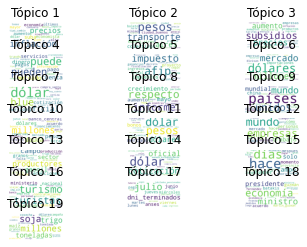

In [43]:
cant_topicos = topics
columnas = 3
if (cant_topicos % columnas) > 0:
    filas = int(cant_topicos/columnas) + 1
else:
    filas = int(cant_topicos/columnas)

for i in range(1, cant_topicos):
    plt.subplot(filas,columnas,i)
    plt.rcParams['figure.figsize'] = [16,15]
    plt.imshow(WordCloud(background_color='white', prefer_horizontal=1.0,collocation_threshold=3,min_word_length=4,)
               .fit_words(dict(lda.show_topic(i, 20))))
    plt.axis("off")
    plt.title("Tópico " + str(i))
plt.show()

In [44]:
#Creating Topic Distance Visualization
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# feed the LDA model into the pyLDAvis instance
lda_viz = gensimvis.prepare(lda, corpus, diccionario)

/home/nando/.work/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [45]:
lda_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18     0.144225  0.041200       1        1  14.472864
0      0.154731 -0.051610       2        1   8.902456
1      0.026469  0.165685       3        1   7.864570
12     0.141952  0.013827       4        1   7.388675
10     0.013463  0.039090       5        1   6.680897
8      0.007144  0.070300       6        1   5.741213
15     0.122941  0.022676       7        1   5.576506
5      0.098756 -0.164672       8        1   5.540587
11    -0.157176  0.153012       9        1   4.972912
4      0.085271 -0.103775      10        1   4.790649
6     -0.022226  0.132563      11        1   4.728593
13     0.104707  0.052089      12        1   4.018799
3      0.059667 -0.095979      13        1   3.989583
17    -0.007656 -0.255158      14        1   2.722413
19     0.002769  0.159579      15        1   2.692841
9      0.019069  0.156680      16        1   2.677857
7     -0.418230 -0.050104      17        1   2.428622
2     -0.019988 -0.077973      18        1   2.199360
16     0.036944 -0.151527      19        1   1.857999
14    -0.392834 -0.055903      20        1   0.752603, topic_info=          Term          Freq         Total Category  logprob  loglift
194      dólar  20641.000000  20641.000000  Default  30.0000  30.0000
146   millones  18664.000000  18664.000000  Default  29.0000  29.0000
188       blue   7181.000000   7181.000000  Default  28.0000  28.0000
66   inflación  12140.000000  12140.000000  Default  27.0000  27.0000
820      pesos  11495.000000  11495.000000  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
857       suba    247.046256   5408.376530  Topic20  -4.3855   1.8033
820      pesos    266.112899  11495.955398  Topic20  -4.3112   1.1236
375      según    241.246867   8886.114838  Topic20  -4.4093   1.2830
225    mercado    245.339838  13185.905264  Topic20  -4.3925   0.9051
764     cotiza    207.461561   1777.620798  Topic20  -4.5602   2.7413

[1465 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2517      2  0.012542  abastecimiento
2517     11  0.206379  abastecimiento
2517     12  0.506255  abastecimiento
2517     13  0.257688  abastecimiento
2517     15  0.015963  abastecimiento
...     ...       ...             ...
505      15  0.036311         últimos
505      16  0.047153         últimos
505      20  0.042614         últimos
2721      3  0.043643    últimos_doce
2721      6  0.949238    últimos_doce

[4710 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 1, 2, 13, 11, 9, 16, 6, 12, 5, 7, 14, 4, 18, 20, 10, 8, 3, 17, 15])

/home/nando/.work/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/nando/.work/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/nando/.work/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/nando/.work/lib/python3.8/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/home/nando/.work/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packagi

### TEST PHRASE MAKING

In [ ]:
nlp = spacy.load("es_core_news_md")

In [ ]:
corpus_df['token_sp'] = corpus_df['text'].apply(nlp)

In [ ]:
propn = pd.DataFrame(corpus_df['token_sp'].iloc[:20].apply(lambda x: [w for w in x if w.tag_ == 'PROPN']))
propn = propn.token_sp.sum()
max(set(propn), key=propn.count)

In [ ]:
def most_freq(column,tag):
    tags = column.apply(lambda x: [w for w in x if w.tag_ == tag]).sum()
    return max(set(tags), key=tags.count)

In [ ]:
most_freq(corpus_df['token_sp'],'ADJ')

In [ ]:
for token in corpus_df['token_sp'].iloc[0]:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_ , token.is_stop)

In [ ]:
example_doc = nlp(corpus_df.text.iloc[0])

for token in example_doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_ , token.is_stop)

In [ ]:
res['text'] = res['text'].astype('str')
res['category'] = res['category'].astype('str')

# helper functions for creating labels
def extract_labels(category_docs, print_word_counts=False):
    """
    Extract labels from documents in the same cluster by concatenating
    most common verbs, objects, and nouns

    Argument:
        category_docs: list of documents, all from the same category or
                       clustering
        print_word_counts: bool, True will print word counts of each type in this category

    Returns:
        label: str, group label derived from concatentating most common
               verb, object, and two most common nouns

    """

    verbs = []
    dobjs = []
    nouns = []
    adjs = []
    
    verb = ''
    dobj = ''
    noun1 = ''
    noun2 = ''

    # for each document, append verbs, dobs, nouns, and adjectives to 
    # running lists for whole cluster
    for i in range(len(category_docs)):
        doc = nlp(category_docs[i])
        for token in doc:
            if token.is_stop==False:
                if token.dep_ == 'ROOT':
                    verbs.append(token.text.lower())

                elif token.dep_=='dobj':
                    dobjs.append(token.lemma_.lower())

                elif token.pos_=='NOUN':
                    nouns.append(token.lemma_.lower())
                    
                elif token.pos_=='ADJ':
                    adjs.append(token.lemma_.lower())

    # for printing out for inspection purposes
    if print_word_counts:
        for word_lst in [verbs, dobjs, nouns, adjs]:
            counter=collections.Counter(word_lst)
            print(counter)
    
    # take most common words of each form
    if len(verbs) > 0:
        verb = collections.Counter(verbs).most_common(1)[0][0]
        
    if len(dobjs) > 0:
        dobj = collections.Counter(dobjs).most_common(1)[0][0]
    
    if len(nouns) > 0:
        noun1 = collections.Counter(nouns).most_common(1)[0][0]
    
    if len(set(nouns)) > 1:
        noun2 = collections.Counter(nouns).most_common(2)[0][0]
    
    # concatenate the most common verb-dobj-noun1-noun2 (if they exist)
    label_words = [verb, dobj]
    
    for word in [noun1, noun2]:
        if word not in label_words:
            label_words.append(word)
    
    if '' in label_words:
        label_words.remove('')
    
    label = '_'.join(label_words)
    
    return label


def apply_and_summarize_labels(df, category_col):
    """
    Assign groups to original documents and provide group counts

    Arguments:
        df: pandas dataframe of original documents of interest to
            cluster
        category_col: str, column name corresponding to categories or clusters

    Returns:
        summary_df: pandas dataframe with model cluster assignment, number
                    of documents in each cluster and derived labels
    """
    
    numerical_labels = df[category_col].unique()
    
    # create dictionary of the numerical category to the generated label
    label_dict = {}
    for label in numerical_labels:
        current_category = list(df[df[category_col]==label].reset_index(drop=True)['text'])
        label_dict[label] = extract_labels(current_category)
        
    # create summary dataframe of numerical labels and counts
    summary_df = (df.groupby(category_col)['text'].count()
                    .reset_index()
                    .rename(columns={'text':'count'})
                    .sort_values('count', ascending=False))
    
    # apply generated labels
    summary_df['label'] = summary_df.apply(lambda x: label_dict[x[category_col]], axis = 1)
    
    return summary_df
    
    cluster_summary = apply_and_summarize_labels(res, 'label_st1')

labeled_clusters = pd.merge(res, cluster_summary[['label_st1', 'label']], on='label_st1', how = 'left')
labeled_clusters[['text', 'category', 'label']].head(20)

labeled_clusters.head(20)

# pivot rows to more columns
label_pivot = labeled_clusters[~labeled_clusters.category.isnull()].drop_duplicates()
label_pivot = label_pivot[label_pivot.label_st1 != -1]
label_pivot['Yes'] = 1

label_pivot = pd.pivot_table(label_pivot, values='Yes', index=['category'], columns=['label'], aggfunc=np.sum)
label_pivot = label_pivot.reset_index()
label_pivot = label_pivot.sort_values([c for c in label_pivot.columns if c != 'category'], ascending = [False]*(len(label_pivot.columns)-1))
label_pivot.to_clipboard(sep = '|', index = False)